In [1]:
# 2016 until April 2017 traindata
# 2017最終週 testdata

In [3]:
# import os
# os.listdir('../input')
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import glob, re
# pd.set_option('display.max_columns',10000); pd.set_option('display.max_rows', 50); np.set_printoptions(threshold=90000)

import sys, os
sys.path.append('../../src/') #モジュールが入っているディレクトリのパスを指定

# import eda
# import config
# import maprepro as mpre
# import maprepro2 as mpre2

In [5]:
path='../../input/'
ar = pd.read_csv(f'{path}air_reserve.csv',)
asi = pd.read_csv(f'{path}air_store_info.csv',)
avd = pd.read_csv(f'{path}air_visit_data.csv',)
di = pd.read_csv(f'{path}date_info.csv',)
# a = pd.read_csv(f'{path}hpg_reserve.csv',)
hsi = pd.read_csv(f'{path}hpg_store_info.csv',)
sa = pd.read_csv(f'{path}sample_submission.csv',)
sir = pd.read_csv(f'{path}store_id_relation.csv',)


In [6]:
print(asi.shape)
print(ar.shape)
print(avd.shape)
print(di.shape)
print(hsi.shape)
print(sa.shape)
print(sir.shape)
print(avd.shape,sa.shape,avd.shape[0]+sa.shape[0])

(829, 5)
(92378, 4)
(252108, 3)
(517, 3)
(4690, 5)
(32019, 2)
(150, 2)
(252108, 3) (32019, 2) 284127


In [7]:
avd

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8


In [8]:
avd.query('air_store_id=="air_db4b38ebe7a7ceff"')[:5]

,air_store_id,visit_date,visitors
225086,air_db4b38ebe7a7ceff,2016-01-01,21
225087,air_db4b38ebe7a7ceff,2016-01-02,9
225088,air_db4b38ebe7a7ceff,2016-01-04,16
225089,air_db4b38ebe7a7ceff,2016-01-05,11
225090,air_db4b38ebe7a7ceff,2016-01-06,10


In [9]:
# air_visit_data
def air_visit_data_maesyori(df):
    df.index = pd.to_datetime(df['visit_date'])
    # 要はデータがない日をNanにしてからfillnaで来店者0にしたいだけ
    # 集約関数を適用する必要があるのでmean()している
    df = df.groupby('air_store_id').apply(lambda g: g['visitors'].resample('1d').mean()).reset_index()
    df['visit_date'] = df['visit_date'].dt.strftime('%Y-%m-%d')
    df['was_nil'] = df['visitors'].isnull()
    df['visitors'].fillna(0, inplace=True)
    return df
    
avd = air_visit_data_maesyori(avd)


In [10]:
avd[:5]

,air_store_id,visit_date,visitors,was_nil
0,air_00a91d42b08b08d9,2016-07-01,35.0,False
1,air_00a91d42b08b08d9,2016-07-02,9.0,False
2,air_00a91d42b08b08d9,2016-07-03,0.0,True
3,air_00a91d42b08b08d9,2016-07-04,20.0,False
4,air_00a91d42b08b08d9,2016-07-05,25.0,False


In [11]:
def creating_reserve_visitor_sum(ar):
    # air_reserve.csvで予約から来訪までの差異を取得できるのでこれを取得して予測に使用する
    # reserve_visitorsとtimedelta_Intを使用する
    from datetime import timedelta 
    ar['visit_datetime'] = pd.to_datetime(ar['visit_datetime'])
    ar['reserve_datetime'] = pd.to_datetime(ar['reserve_datetime'])
    ar['timedelta'] = ar['visit_datetime'] - ar['reserve_datetime'] 
    # ar.dtypes
    ar["timedelta_Int"] = (ar["timedelta"] / timedelta(days=1))
    # 必要なのは予約から来訪までの差異だけなので思い切って予約した時間や来訪した時間は落としてしまう
    ar = ar.drop(['reserve_datetime','timedelta'], axis='columns')
    
    # arのvisit_datetimeを日単位にして、groupby['visit_datetime']してreserve_visitorsのsumをとる
    # timedeltaの周期性を保つ方法が思い浮かばなかったので
    # 単に店ごとにreserve_visitorを足す
    ar.query('air_store_id=="air_db4b38ebe7a7ceff"')[:5]
    ar['visit_date'] = ar['visit_datetime'].dt.strftime('%Y-%m-%d')
    ar = ar.groupby(['air_store_id','visit_date'])['reserve_visitors'].sum().reset_index()
    return ar

ar = creating_reserve_visitor_sum(ar)

In [12]:
ar

,air_store_id,visit_date,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,2
1,air_00a91d42b08b08d9,2016-12-05,9
2,air_00a91d42b08b08d9,2016-12-14,18
3,air_00a91d42b08b08d9,2016-12-17,2
4,air_00a91d42b08b08d9,2016-12-20,4
...,...,...,...
29825,air_fea5dc9594450608,2017-04-22,2
29826,air_fea5dc9594450608,2017-04-25,2
29827,air_fea5dc9594450608,2017-04-28,3
29828,air_fea5dc9594450608,2017-05-20,6


In [13]:
# date_info
date_info = pd.read_csv(f'{path}/date_info.csv')
def date_info_maesyori(df):
    df.rename(columns={'calendar_date': 'visit_date','holiday_flg': 'is_holiday'}, inplace=True)
    df['prev_day_is_holiday'] = df['is_holiday'].shift().fillna(0)
    df['next_day_is_holiday'] = df['is_holiday'].shift(-1).fillna(0)
    return df

date_info = date_info_maesyori(date_info)

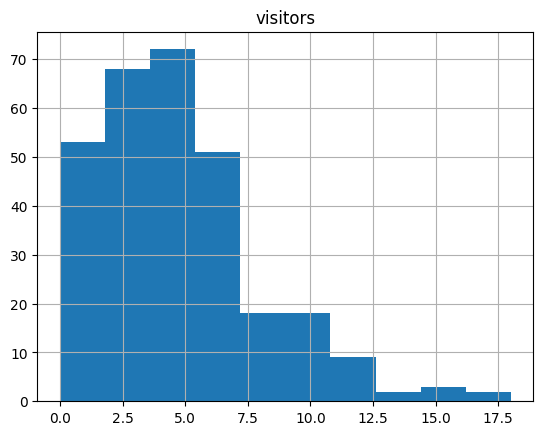

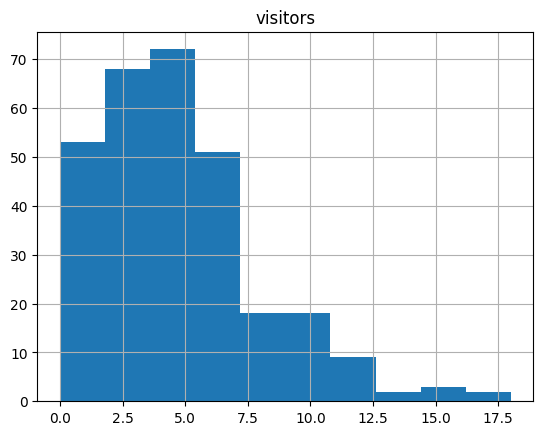

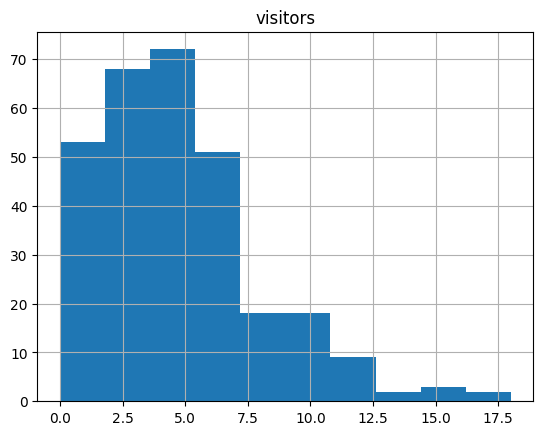

In [14]:
# 店の売り上げは正規標本っていうよりポアソン…?まあ正規標本か…
store_list = pd.unique(avd.air_store_id)
for store in store_list[:3]:
    avd.query('air_store_id=="air_fff68b929994bfbd"').hist()

In [15]:
def find_outliers(series):
    # True,falseが返る
    # 2.4は恣意的なのでナンセンスかも
    # print(series.mean())
    return (series - series.mean()) / series.std() > 2.4

def cap_values(series):
    outliers = find_outliers(series)
    max_val = series[~outliers].max()
    series[outliers] = max_val
    return series

def is_outlier_and_transformation_to_clipped_value(avd):
    stores = avd.groupby('air_store_id')
    avd['is_outlier'] = stores.apply(lambda g: find_outliers(g['visitors'])).values
    avd['visitors_capped'] = stores.apply(lambda g: cap_values(g['visitors'])).values
    return avd
avd = is_outlier_and_transformation_to_clipped_value(avd)


In [16]:
def transformation_of_sample_submission(sa):
    # sample_submissionファイルを前処理
    # store_idとvisit_dateに分割
    # テストのフラグを立てる
    # 目的変数をnanに
    # 連番を降る
    sa['air_store_id'] = sa['id'].str.slice(0, 20)
    sa['visit_date'] = sa['id'].str.slice(21)
    sa['is_test'] = True
    sa['visitors'] = np.nan
    sa['test_number'] = range(len(sa))
    return sa
sa = transformation_of_sample_submission(sa)

In [17]:
sa.dtypes

id               object
visitors        float64
air_store_id     object
visit_date       object
is_test            bool
test_number       int64
dtype: object

In [18]:
'''air_visit+sample_submission+date_info+air_store_info'''
def all_integration():
    '''今まで作成した特徴量を１つのデータフレームに統合'''
    data = pd.concat((avd, sa.drop('id', axis='columns')))
    data = pd.merge(data,ar,on=["air_store_id","visit_date"],how='left')
    # # reserve_visitorsがない=レジにデータがない→予約数は0としてもよいと考えた
    data['reserve_visitors'].fillna(0, inplace=True)
    data['is_test'].fillna(False, inplace=True)
    data = pd.merge(data, date_info, how='left', left_on=['visit_date'], right_on=['visit_date'])
    data = pd.merge(left=data, right=asi, on='air_store_id', how='left')
    # data = pd.merge(left=data, right=sir, on='air_store_id', how='left')
    # data = pd.merge(left=data, right=hsi, on='hpg_store_id', how='left')
    data['is_test'].fillna(False, inplace=True)
    print(data.shape)
    return data

data = all_integration()
data

(328298, 17)


,air_store_id,visit_date,visitors,was_nil,is_outlier,visitors_capped,is_test,test_number,reserve_visitors,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,35.0,False,NaN,0.0,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,9.0,False,NaN,0.0,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
2,air_00a91d42b08b08d9,2016-07-03,0.0,True,False,0.0,False,NaN,0.0,Sunday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
3,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,20.0,False,NaN,0.0,Monday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
4,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,25.0,False,NaN,0.0,Tuesday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328293,air_fff68b929994bfbd,2017-05-27,NaN,NaN,NaN,NaN,True,32014.0,0.0,Saturday,0,0.0,0.0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288
328294,air_fff68b929994bfbd,2017-05-28,NaN,NaN,NaN,NaN,True,32015.0,0.0,Sunday,0,0.0,0.0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288
328295,air_fff68b929994bfbd,2017-05-29,NaN,NaN,NaN,NaN,True,32016.0,0.0,Monday,0,0.0,0.0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288
328296,air_fff68b929994bfbd,2017-05-30,NaN,NaN,NaN,NaN,True,32017.0,0.0,Tuesday,0,0.0,0.0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288


In [19]:
data.isnull().sum()

air_store_id                0
visit_date                  0
visitors                32019
was_nil                 32019
is_outlier              32019
visitors_capped         32019
is_test                     0
test_number            296279
reserve_visitors            0
day_of_week                 0
is_holiday                  0
prev_day_is_holiday         0
next_day_is_holiday         0
air_genre_name              0
air_area_name               0
latitude                    0
longitude                   0
dtype: int64

In [20]:
tmp = data.air_area_name.str.split(' ',expand=True)
tmp = tmp.rename({0:'Prefecture',1:'municipalities'},axis=1)  
tmp = tmp[['Prefecture','municipalities']]
data = pd.concat([data,tmp], axis=1).drop('air_area_name', axis=1)
data

,air_store_id,visit_date,visitors,was_nil,is_outlier,visitors_capped,is_test,test_number,reserve_visitors,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,latitude,longitude,Prefecture,municipalities
0,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,35.0,False,NaN,0.0,Friday,0,0.0,0.0,Italian/French,35.694003,139.753595,Tōkyō-to,Chiyoda-ku
1,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,9.0,False,NaN,0.0,Saturday,0,0.0,0.0,Italian/French,35.694003,139.753595,Tōkyō-to,Chiyoda-ku
2,air_00a91d42b08b08d9,2016-07-03,0.0,True,False,0.0,False,NaN,0.0,Sunday,0,0.0,0.0,Italian/French,35.694003,139.753595,Tōkyō-to,Chiyoda-ku
3,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,20.0,False,NaN,0.0,Monday,0,0.0,0.0,Italian/French,35.694003,139.753595,Tōkyō-to,Chiyoda-ku
4,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,25.0,False,NaN,0.0,Tuesday,0,0.0,0.0,Italian/French,35.694003,139.753595,Tōkyō-to,Chiyoda-ku
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328293,air_fff68b929994bfbd,2017-05-27,NaN,NaN,NaN,NaN,True,32014.0,0.0,Saturday,0,0.0,0.0,Bar/Cocktail,35.708146,139.666288,Tōkyō-to,Nakano-ku
328294,air_fff68b929994bfbd,2017-05-28,NaN,NaN,NaN,NaN,True,32015.0,0.0,Sunday,0,0.0,0.0,Bar/Cocktail,35.708146,139.666288,Tōkyō-to,Nakano-ku
328295,air_fff68b929994bfbd,2017-05-29,NaN,NaN,NaN,NaN,True,32016.0,0.0,Monday,0,0.0,0.0,Bar/Cocktail,35.708146,139.666288,Tōkyō-to,Nakano-ku
328296,air_fff68b929994bfbd,2017-05-30,NaN,NaN,NaN,NaN,True,32017.0,0.0,Tuesday,0,0.0,0.0,Bar/Cocktail,35.708146,139.666288,Tōkyō-to,Nakano-ku


In [21]:
data.dtypes
print(data.isnull().sum())

air_store_id                0
visit_date                  0
visitors                32019
was_nil                 32019
is_outlier              32019
visitors_capped         32019
is_test                     0
test_number            296279
reserve_visitors            0
day_of_week                 0
is_holiday                  0
prev_day_is_holiday         0
next_day_is_holiday         0
air_genre_name              0
latitude                    0
longitude                   0
Prefecture                  0
municipalities              0
dtype: int64


In [22]:
def transformation_of_data(data):
    data['visit_date'] = pd.to_datetime(data['visit_date'])
    data.index = data['visit_date']
    # astypeでtrue,false→1,0に変換できる
    data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
    data['day_of_month'] = data['visit_date'].dt.day
    data['dow'] = data['visit_date'].dt.dayofweek
    data['visitors_capped_log1p'] = np.log1p(data['visitors_capped'])
    data = pd.get_dummies(data, columns=['air_genre_name'])
    data = pd.get_dummies(data, columns=['Prefecture','municipalities'])
    
    print(data.shape)
    
    # target_encoding かなり有効。精度が0.2くらい上がる
    tmp = data.groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
    data = pd.merge(data, tmp, how='left', on=['air_store_id','dow']) 
    tmp = data.groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
    data = pd.merge(data, tmp, how='left', on=['air_store_id','dow']) 
    tmp = data.groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
    data = pd.merge(data, tmp, how='left', on=['air_store_id','dow']) 
    tmp = data.groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
    data = pd.merge(data, tmp, how='left', on=['air_store_id','dow']) 
    tmp = data.groupby(['air_store_id','dow'], as_index=False)['visitors'].std().rename(columns={'visitors':'std_visitors'})
    data = pd.merge(data, tmp, how='left', on=['air_store_id','dow']) 
    tmp = data.groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
    data = pd.merge(data, tmp, how='left', on=['air_store_id','dow']) 
    
    # 相対的な緯度・経度
    data['difference_max_lat'] = data['latitude'].max() - data['latitude']
    data['difference_max_long'] = data['longitude'].max() - data['longitude']
    data['plus_longitude_latitude'] = data['longitude'] + data['latitude']
    data['Product_longitude_latitude'] = data['longitude'] * data['latitude']

    return data

data = transformation_of_data(data)

(328298, 97)


In [23]:
print(data.isnull().sum())

air_store_id                      0
visit_date                        0
visitors                      32019
was_nil                       32019
is_outlier                    32019
                              ...  
count_observations                0
difference_max_lat                0
difference_max_long               0
plus_longitude_latitude           0
Product_longitude_latitude        0
Length: 107, dtype: int64


In [24]:
sa.visit_date.min(),sa.visit_date.max()

('2017-04-23', '2017-05-31')

In [25]:
sa['visit_date'] = pd.to_datetime(sa['visit_date'])


In [26]:
# train = data[(data['is_test'] == False)]
# こっちにすると損失がかなーり減る
train = data[(data['is_test'] == False) & (data['is_outlier'] == False) & (data['was_nil'] == False)].reset_index(drop=True)
test = data[data['is_test']].sort_values('test_number')

drop_list = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
           'is_outlier', 'visitors', 'visitors_capped', 'day_of_week']
# to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
#            'is_outlier', 'visitors_capped', 'visitors', 'air_area_name',
#            'station_id', 'station_latitude', 'station_longitude', 'station_vincenty',
#            'station_great_circle']

train = train.drop(drop_list, axis='columns')
y = train['visitors_capped_log1p']
train = train.drop('visitors_capped_log1p', axis='columns')
test = test.drop(drop_list, axis='columns')
test = test.drop('visitors_capped_log1p', axis='columns')
test = test.reset_index(drop=True)

In [27]:
train

,reserve_visitors,is_holiday,prev_day_is_holiday,next_day_is_holiday,latitude,longitude,is_weekend,day_of_month,dow,air_genre_name_Asian,...,min_visitors,mean_visitors,median_visitors,max_visitors,std_visitors,count_observations,difference_max_lat,difference_max_long,plus_longitude_latitude,Product_longitude_latitude
0,0.0,0,0.0,0.0,35.694003,139.753595,0,1,4,False,...,0.0,33.953488,35.0,57.0,12.809880,43,8.326629,4.519803,175.447598,4988.365201
1,0.0,0,0.0,0.0,35.694003,139.753595,1,2,5,False,...,0.0,13.232558,9.0,99.0,16.493631,43,8.326629,4.519803,175.447598,4988.365201
2,0.0,0,0.0,0.0,35.694003,139.753595,0,4,0,False,...,0.0,18.714286,18.0,47.0,12.059377,42,8.326629,4.519803,175.447598,4988.365201
3,0.0,0,0.0,0.0,35.694003,139.753595,0,5,1,False,...,0.0,23.190476,24.0,43.0,10.305665,42,8.326629,4.519803,175.447598,4988.365201
4,0.0,0,0.0,0.0,35.694003,139.753595,0,6,2,False,...,0.0,26.785714,27.5,52.0,10.572712,42,8.326629,4.519803,175.447598,4988.365201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247219,0.0,0,0.0,0.0,35.708146,139.666288,0,18,1,False,...,0.0,4.095238,4.0,11.0,2.774532,42,8.312486,4.607110,175.374434,4987.224161
247220,0.0,0,0.0,0.0,35.708146,139.666288,0,19,2,False,...,0.0,4.523810,4.0,12.0,3.030239,42,8.312486,4.607110,175.374434,4987.224161
247221,0.0,0,0.0,0.0,35.708146,139.666288,0,20,3,False,...,0.0,4.595238,4.0,12.0,2.846132,42,8.312486,4.607110,175.374434,4987.224161
247222,0.0,0,0.0,0.0,35.708146,139.666288,0,21,4,False,...,1.0,5.627907,5.0,17.0,3.505256,43,8.312486,4.607110,175.374434,4987.224161


In [28]:
test

,reserve_visitors,is_holiday,prev_day_is_holiday,next_day_is_holiday,latitude,longitude,is_weekend,day_of_month,dow,air_genre_name_Asian,...,min_visitors,mean_visitors,median_visitors,max_visitors,std_visitors,count_observations,difference_max_lat,difference_max_long,plus_longitude_latitude,Product_longitude_latitude
0,0.0,0,0.0,0.0,35.694003,139.753595,1,23,6,False,...,0.0,0.047619,0.0,2.0,0.308607,42,8.326629,4.519803,175.447598,4988.365201
1,0.0,0,0.0,0.0,35.694003,139.753595,0,24,0,False,...,0.0,18.714286,18.0,47.0,12.059377,42,8.326629,4.519803,175.447598,4988.365201
2,0.0,0,0.0,0.0,35.694003,139.753595,0,25,1,False,...,0.0,23.190476,24.0,43.0,10.305665,42,8.326629,4.519803,175.447598,4988.365201
3,0.0,0,0.0,0.0,35.694003,139.753595,0,26,2,False,...,0.0,26.785714,27.5,52.0,10.572712,42,8.326629,4.519803,175.447598,4988.365201
4,0.0,0,0.0,0.0,35.694003,139.753595,0,27,3,False,...,0.0,27.023810,29.0,47.0,11.171584,42,8.326629,4.519803,175.447598,4988.365201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,0.0,0,0.0,0.0,35.708146,139.666288,1,27,5,False,...,0.0,7.093023,7.0,18.0,3.784769,43,8.312486,4.607110,175.374434,4987.224161
32015,0.0,0,0.0,0.0,35.708146,139.666288,1,28,6,False,...,0.0,2.857143,2.0,10.0,2.772438,42,8.312486,4.607110,175.374434,4987.224161
32016,0.0,0,0.0,0.0,35.708146,139.666288,0,29,0,False,...,0.0,3.500000,3.0,14.0,3.054385,42,8.312486,4.607110,175.374434,4987.224161
32017,0.0,0,0.0,0.0,35.708146,139.666288,0,30,1,False,...,0.0,4.095238,4.0,11.0,2.774532,42,8.312486,4.607110,175.374434,4987.224161


In [29]:
train.shape,y.shape,test.shape

((247224, 97), (247224,), (32019, 97))

In [30]:
# # 積集合
# a = set(train.columns.values)
# b = set(test.columns.values)
# s_intersection = a-b
# print(s_intersection)

In [31]:
train.describe()
y.describe()

count    247224.000000
mean          2.781664
std           0.797619
min           0.693147
25%           2.302585
50%           2.890372
75%           3.367296
max           5.117994
Name: visitors_capped_log1p, dtype: float64

In [32]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(train, y)
# print("Result on validation data: ", clf.evaluate(X_val, y_val))
from sklearn.metrics import mean_squared_error as mse
mse(y,lr.predict(train))


0.2926172103777789

In [38]:
from sklearn.model_selection import KFold
import lightgbm as lgb

# Now you can use 'lgb' to work with LightGBM


In [39]:
# X_train, X_valid, y_train, y_valid = train_test_split(train, y, test_size=0.25)
feature_importances = pd.DataFrame(index=train.columns)
test_preds = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(kf.split(train, y)):
    print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
    print(train_idx.shape, test_idx.shape)
        
    X_train, X_valid = train.iloc[train_idx], train.iloc[test_idx]
    y_train, y_valid = y[train_idx], y[test_idx]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    lgbm_params = {
            "objective": "regression",
            "learning_rate": 0.05,
            "boosting_type": "gbdt",
            # "min_data_in_leaf":600,
            # "max_bin": 196,
            # "feature_fraction":0.4,
            # "lambda_l1":36, "lambda_l2":80,
            # "max_depth":10,
            # "num_leaves":1000,
            # "metric": "mae",
            'metric': 'rmse',
            'verbose': 1,
            "tree_learner": "voting",
            "n_jobs": 9,
            "seed": 71
        }

    model = lgb.train(
        lgbm_params, lgb_train,
        valid_sets=[lgb_train,lgb_eval],
        valid_names=['train', 'valid'],
        verbose_eval=100,
        num_boost_round=10000,
        early_stopping_rounds=1000,
    )
    test_pred = model.predict(test)
    test_preds.append(test_pred)
    
    y_pred = model.predict(X_valid)
    score = mse(y_valid, y_pred)
    score = np.expm1(mse(y_valid, y_pred))
    print(f"Fold-{fold+1} | OOF Score: {score}")

# val_mean = np.mean(val_scores)
# val_std = np.std(val_scores)

# print('Local RMSLE: {:.5f} (±{:.5f})'.format(val_mean, val_std))


--------------- > Fold 1 < ---------------
(197779,) (49445,)


TypeError: train() got an unexpected keyword argument 'verbose_eval'

In [34]:
sub = sa['id'].to_frame()
sub['visitors'] = 0
test_preds = np.expm1(test_preds)
sub['visitors'] = sum(test_preds)/5
# sub['visitors'] = np.expm1(sub['visitors'])

In [35]:
sub.describe()

,visitors
count,32019.000
mean,16.970
std,12.203
min,0.655
25%,7.671
50%,13.926
75%,23.380
max,140.585


In [36]:
import datetime
now = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
sub.to_csv(f'../../output/{now}.csv',index=False)
pd.read_csv(f'../../output/{now}.csv')

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,1.733
1,air_00a91d42b08b08d9_2017-04-24,18.758
2,air_00a91d42b08b08d9_2017-04-25,23.296
3,air_00a91d42b08b08d9_2017-04-26,26.649
4,air_00a91d42b08b08d9_2017-04-27,28.106
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,6.390
32015,air_fff68b929994bfbd_2017-05-28,3.385
32016,air_fff68b929994bfbd_2017-05-29,3.473
32017,air_fff68b929994bfbd_2017-05-30,4.107


In [37]:
now

'2021-12-26-22-47-12'

In [38]:
%matplotlib inline
import shap
shap.initjs()

In [39]:
# test = shap.sample(test, 1000)
explainer = shap.TreeExplainer(
    model=model,
    data=test,
    feature_perturbation='interventional'
)
# Consider using shap.sample(data, 100) to create a smaller background data set.


In [40]:
train.shape,test.shape

((247224, 97), (32019, 97))

In [41]:
# test = shap.sample(test, 10000)
test_shap_values = explainer(test,check_additivity=False)

100%|===================| 32002/32019 [08:17<00:00]        

In [45]:
test_shap_values[0]

.values =
array([-0.0065, -0.0039,  0.0055, -0.0072,  0.0026, -0.0026, -0.0003,  0.0037,  0.029 ,  0.    ,
        0.0009,  0.0002,  0.    ,  0.0102,  0.    ,  0.0129, -0.    , -0.0005, -0.0001, -0.0004,
       -0.0005,  0.0001,  0.0006,  0.    ,  0.    ,  0.    , -0.0003, -0.    , -0.0003, -0.0001,
       -0.0082,  0.0001,  0.    ,  0.    ,  0.    , -0.0001,  0.    ,  0.0042, -0.0001,  0.    ,
        0.    ,  0.    ,  0.0001, -0.0003,  0.    , -0.0001,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.0019,  0.    ,  0.    , -0.0002,  0.    ,  0.0008, -0.0007,  0.0002,  0.    ,
        0.0002,  0.0001,  0.    ,  0.    ,  0.    ,  0.    ,  0.0005,  0.    , -0.0003,  0.    ,
       -0.0008,  0.0002,  0.    ,  0.0011,  0.0012,  0.    ,  0.0002,  0.    ,  0.    ,  0.    ,
        0.    ,  0.0002,  0.    ,  0.001 ,  0.    , -0.001 , -0.0013,  0.0025, -0.9448, -0.1003,
        0.0349, -0.6362,  0.0052, -0.0001,  0.0001, -0.0173,  0.0028])

.base_values =
2.610600062524853

.data =
arr

In [46]:
test.head(1)

,reserve_visitors,is_holiday,prev_day_is_holiday,next_day_is_holiday,latitude,longitude,is_weekend,day_of_month,dow,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food,Prefecture_Fukuoka-ken,Prefecture_Hiroshima-ken,Prefecture_Hokkaidō,Prefecture_Hyōgo-ken,Prefecture_Miyagi-ken,Prefecture_Niigata-ken,Prefecture_Shizuoka-ken,Prefecture_Tōkyō-to,Prefecture_Ōsaka-fu,municipalities_Abashiri-shi,municipalities_Adachi-ku,municipalities_Amagasaki-shi,municipalities_Asahikawa-shi,municipalities_Bunkyō-ku,municipalities_Chiyoda-ku,municipalities_Chūō-ku,municipalities_Edogawa-ku,municipalities_Fuchū-shi,municipalities_Fukuoka-shi,municipalities_Fukuyama-shi,municipalities_Hamamatsu-shi,municipalities_Higashiōsaka-shi,municipalities_Himeji-shi,municipalities_Hiroshima-shi,municipalities_Itabashi-ku,municipalities_Itoshima-shi,municipalities_Kakogawa-shi,municipalities_Kashiwazaki-shi,municipalities_Katsushika-ku,municipalities_Katō-gun,municipalities_Kita-ku,municipalities_Kitakyūshū-shi,municipalities_Koganei-shi,municipalities_Kurume-shi,municipalities_Kōbe-shi,municipalities_Kōtō-ku,municipalities_Machida-shi,municipalities_Meguro-ku,municipalities_Minato-ku,municipalities_Musashino-shi,municipalities_Nagaoka-shi,municipalities_Nakano-ku,municipalities_Nerima-ku,municipalities_Neyagawa-shi,municipalities_Niigata-shi,municipalities_Nishinomiya-shi,municipalities_Numazu-shi,municipalities_Sakai-shi,municipalities_Sapporo-shi,municipalities_Sendai-shi,municipalities_Setagaya-ku,municipalities_Shibuya-ku,municipalities_Shinagawa-ku,municipalities_Shinjuku-ku,municipalities_Shizuoka-shi,municipalities_Suginami-ku,municipalities_Suita-shi,municipalities_Tachikawa-shi,municipalities_Taitō-ku,municipalities_Takarazuka-shi,municipalities_Toshima-ku,municipalities_Yame-shi,municipalities_Ōsaka-shi,municipalities_Ōta-ku,min_visitors,mean_visitors,median_visitors,max_visitors,std_visitors,count_observations,difference_max_lat,difference_max_long,plus_longitude_latitude,Product_longitude_latitude
0,0.0,0,0.0,0.0,35.694,139.754,1,23,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.048,0.0,2.0,0.309,42,8.327,4.52,175.448,4988.365


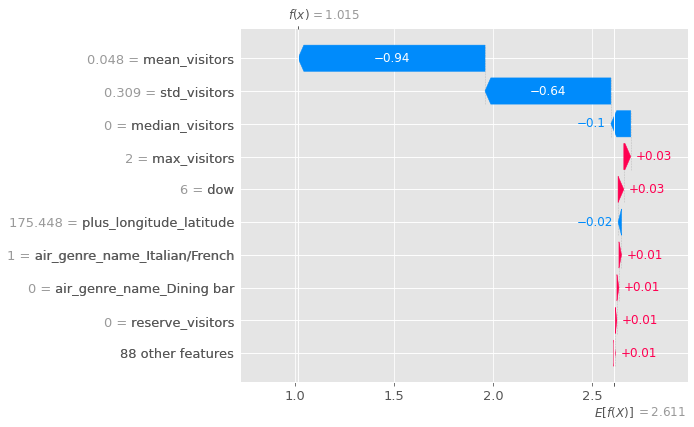

In [56]:
shap.plots.waterfall(test_shap_values[0])

In [48]:
test

,reserve_visitors,is_holiday,prev_day_is_holiday,next_day_is_holiday,latitude,longitude,is_weekend,day_of_month,dow,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food,Prefecture_Fukuoka-ken,Prefecture_Hiroshima-ken,Prefecture_Hokkaidō,Prefecture_Hyōgo-ken,Prefecture_Miyagi-ken,Prefecture_Niigata-ken,Prefecture_Shizuoka-ken,Prefecture_Tōkyō-to,Prefecture_Ōsaka-fu,municipalities_Abashiri-shi,municipalities_Adachi-ku,municipalities_Amagasaki-shi,municipalities_Asahikawa-shi,municipalities_Bunkyō-ku,municipalities_Chiyoda-ku,municipalities_Chūō-ku,municipalities_Edogawa-ku,municipalities_Fuchū-shi,municipalities_Fukuoka-shi,municipalities_Fukuyama-shi,municipalities_Hamamatsu-shi,municipalities_Higashiōsaka-shi,municipalities_Himeji-shi,municipalities_Hiroshima-shi,municipalities_Itabashi-ku,municipalities_Itoshima-shi,municipalities_Kakogawa-shi,municipalities_Kashiwazaki-shi,municipalities_Katsushika-ku,municipalities_Katō-gun,municipalities_Kita-ku,municipalities_Kitakyūshū-shi,municipalities_Koganei-shi,municipalities_Kurume-shi,municipalities_Kōbe-shi,municipalities_Kōtō-ku,municipalities_Machida-shi,municipalities_Meguro-ku,municipalities_Minato-ku,municipalities_Musashino-shi,municipalities_Nagaoka-shi,municipalities_Nakano-ku,municipalities_Nerima-ku,municipalities_Neyagawa-shi,municipalities_Niigata-shi,municipalities_Nishinomiya-shi,municipalities_Numazu-shi,municipalities_Sakai-shi,municipalities_Sapporo-shi,municipalities_Sendai-shi,municipalities_Setagaya-ku,municipalities_Shibuya-ku,municipalities_Shinagawa-ku,municipalities_Shinjuku-ku,municipalities_Shizuoka-shi,municipalities_Suginami-ku,municipalities_Suita-shi,municipalities_Tachikawa-shi,municipalities_Taitō-ku,municipalities_Takarazuka-shi,municipalities_Toshima-ku,municipalities_Yame-shi,municipalities_Ōsaka-shi,municipalities_Ōta-ku,min_visitors,mean_visitors,median_visitors,max_visitors,std_visitors,count_observations,difference_max_lat,difference_max_long,plus_longitude_latitude,Product_longitude_latitude
0,0.0,0,0.0,0.0,35.694,139.754,1,23,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.048,0.0,2.0,0.309,42,8.327,4.520,175.448,4988.365
1,0.0,0,0.0,0.0,35.694,139.754,0,24,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,18.714,18.0,47.0,12.059,42,8.327,4.520,175.448,4988.365
2,0.0,0,0.0,0.0,35.694,139.754,0,25,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,23.190,24.0,43.0,10.306,42,8.327,4.520,175.448,4988.365
3,0.0,0,0.0,0.0,35.694,139.754,0,26,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,26.786,27.5,52.0,10.573,42,8.327,4.520,175.448,4988.365
4,0.0,0,0.0,0.0,35.694,139.754,0,27,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,27.024,29.0,47.0,11.172,42,8.327,4.520,175.448,4988.365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [58]:
test.columns

Index(['reserve_visitors', 'is_holiday', 'prev_day_is_holiday', 'next_day_is_holiday', 'latitude',
       'longitude', 'is_weekend', 'day_of_month', 'dow', 'air_genre_name_Asian',
       'air_genre_name_Bar/Cocktail', 'air_genre_name_Cafe/Sweets',
       'air_genre_name_Creative cuisine', 'air_genre_name_Dining bar',
       'air_genre_name_International cuisine', 'air_genre_name_Italian/French',
       'air_genre_name_Izakaya', 'air_genre_name_Japanese food', 'air_genre_name_Karaoke/Party',
       'air_genre_name_Okonomiyaki/Monja/Teppanyaki', 'air_genre_name_Other',
       'air_genre_name_Western food', 'air_genre_name_Yakiniku/Korean food',
       'Prefecture_Fukuoka-ken', 'Prefecture_Hiroshima-ken', 'Prefecture_Hokkaidō',
       'Prefecture_Hyōgo-ken', 'Prefecture_Miyagi-ken', 'Prefecture_Niigata-ken',
       'Prefecture_Shizuoka-ken', 'Prefecture_Tōkyō-to', 'Prefecture_Ōsaka-fu',
       'municipalities_Abashiri-shi', 'municipalities_Adachi-ku', 'municipalities_Amagasaki-shi',
     

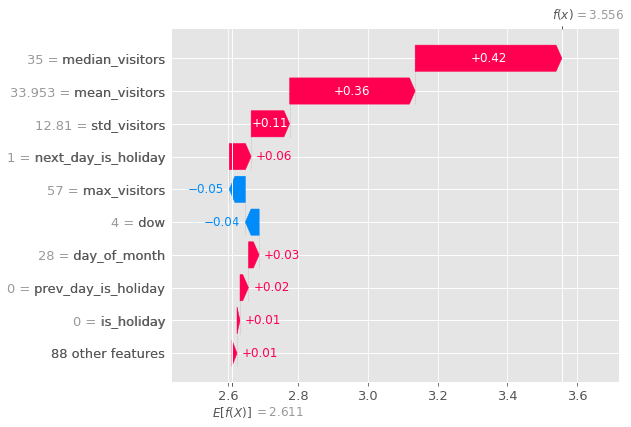

In [57]:
shap.plots.waterfall(test_shap_values[5])

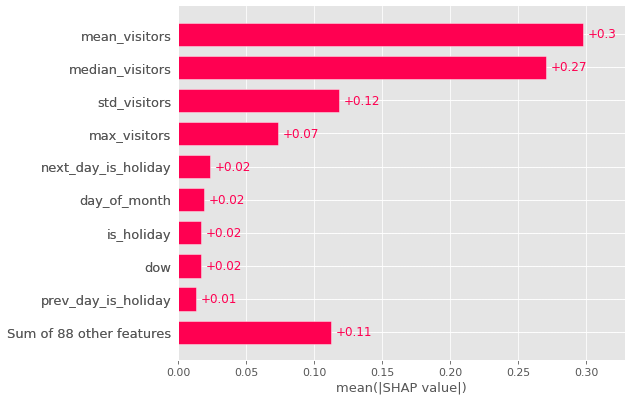

In [50]:
shap.plots.bar(shap_values=test_shap_values)

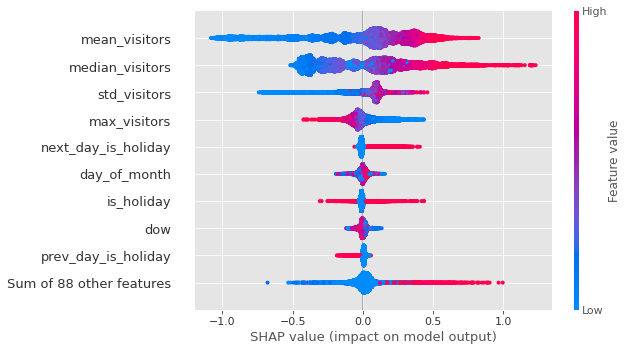

In [51]:
shap.plots.beeswarm(shap_values=test_shap_values)

In [269]:
sub

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,1.712
1,air_00a91d42b08b08d9_2017-04-24,18.758
2,air_00a91d42b08b08d9_2017-04-25,23.296
3,air_00a91d42b08b08d9_2017-04-26,26.649
4,air_00a91d42b08b08d9_2017-04-27,28.106
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,6.378
32015,air_fff68b929994bfbd_2017-05-28,3.377
32016,air_fff68b929994bfbd_2017-05-29,3.473
32017,air_fff68b929994bfbd_2017-05-30,4.107


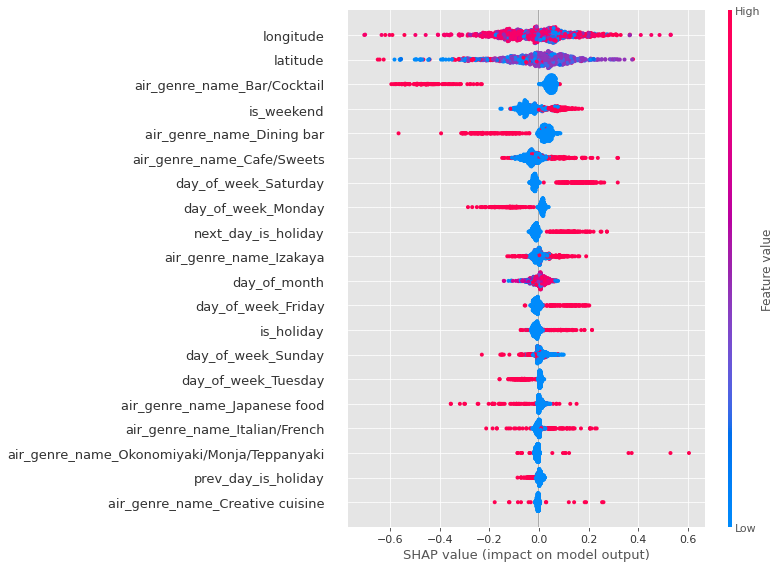

In [81]:
# そして、TreeExplainer を使って、モデルがどのように推論するか解釈したいデータについて SHAP Value を計算しよう。
# この SHAP Value は、入力したのと同じ次元と要素数で得られる。 そして、値が大きいほど推論において影響が大きいと見なすことができる。
tr_x_shap_values = explainer.shap_values(test)
# つまり、行方向に見れば「特定の予測に、それぞれの特徴量がどれくらい寄与したか」と解釈できる。 
# 同様に、列方向に見れば「予測全体で、その特徴量がどれくらい寄与したか」と解釈できる。

# Summary Plot
# このグラフは、デフォルトでは特徴量ごとに SHAP Valueを一軸の散布図として描画する。

shap.summary_plot(shap_values=tr_x_shap_values,
                  features=test,
                  feature_names=test.columns)
